# Kernel Density Estimation (KDE) (Part 1)

---

## 0 — Short Summary (One-Liner)
**Kernel Density Estimation (KDE)** is a non-parametric way to estimate the probability density function of a random variable by placing a smooth kernel (e.g., Gaussian) on each data point and summing them—useful for density estimation, anomaly detection, and exploratory data analysis.

---

## 1 — What KDE Models and Why It’s Useful
* **Non-parametric Estimation:** KDE estimates the density $\hat f(x)$ from samples $\{x_i\}_{i=1}^n$ without assuming a specific parametric family (like Normal or Poisson).
* **Key Use Cases:** * **Anomaly Detection:** Identify low-density points as outliers.
    * **Smoothing:** Better than histograms for visualizing the "true" underlying distribution.
    * **Generative Modeling:** KDE gives a continuous estimate $\hat f(x)$, allowing us to compute likelihoods and percentiles.

---

## 2 — The Math (Essential Formulas)

For a $d$-dimensional variable $\mathbf{x} \in \mathbb{R}^d$, the multivariate KDE with an isotropic bandwidth $h$ and kernel $K(\cdot)$ is:

$$\hat f(x) = \frac{1}{n h^d} \sum_{i=1}^n K\left(\frac{x - x_i}{h}\right)$$

### Common Kernels:
* **Gaussian (Default):** $K(u) = (2\pi)^{-d/2}\exp(-\frac{1}{2} \|u\|^2)$
* **Others:** Epanechnikov, Tophat, Exponential, Linear, Cosine (all supported in `sklearn`).

If we use a full **bandwidth matrix** $H$ (allowing different smoothing for different axes), the formula becomes:

$$\hat f(x) = \frac{1}{n \sqrt{|H|}} \sum_{i=1}^n K\left(H^{-1/2}(x-x_i)\right)$$

---

## 3 — Main Hyperparameters (Scikit-Learn Mapping)

* **`bandwidth` ($h$):** The most critical parameter.
    * **Small $h$:** Narrow kernels $\rightarrow$ "Wiggly" estimate $\rightarrow$ Low bias, high variance (**Overfit**).
    * **Large $h$:** Wide kernels $\rightarrow$ Very smooth estimate $\rightarrow$ High bias, low variance (**Underfit**).
* **`kernel`:** Shape of the distribution placed on each point (`'gaussian'`, `'tophat'`, `'epanechnikov'`, etc.).
* **`algorithm`:** Tree-based acceleration (`'ball_tree'`, `'kd_tree'`).
* **`metric`:** Distance metric (usually Euclidean).



---

## 4 — Bandwidth Selection

1.  **Silverman’s Rule of Thumb:** $h = 1.06 \cdot \sigma \cdot n^{-1/5}$ (Best for Gaussian-like data).
2.  **Scott’s Rule:** Scales roughly by $\propto n^{-1/(d+4)}$.
3.  **Cross-Validation (Gold Standard):** Use `GridSearchCV` to choose the bandwidth that maximizes the **held-out log-likelihood**.

---

## 5 — Computational Complexity & Practical Notes
* **Naïve Evaluation:** $O(m \cdot n \cdot d)$ for $m$ query points and $n$ samples.
* **Curse of Dimensionality:** In high dimensions ($d > 10$), KDE becomes unreliable and sparse.
* **Pre-processing:** We **must standardize** our features before KDE because the bandwidth is highly sensitive to feature scales.

---

## 6 — When KDE Fails & Mitigations

| Failure Mode | Mitigation |
| :--- | :--- |
| **High Dimensions** | Use PCA or Autoencoders to reduce $d$ first. |
| **Categorical Data** | Use specialized kernels or discrete probability models. |
| **Boundary Effects** | For non-negative data (like age/income), use a log-transform first. |
| **Large Datasets** | Use tree-based approximations or sub-sample the data. |

---

## 7 — Interview-Friendly Bullets

* **What is it?** A non-parametric "sum-of-kernels" approach to density estimation.
* **GMM vs KDE:** GMM is semi-parametric (assumes $K$ clusters); KDE is fully non-parametric (essentially places a cluster on every single data point).
* **Sensitivity:** Extremely sensitive to the **bandwidth** parameter; less sensitive to the specific kernel shape.
* **Complexity:** Slower than GMM or K-Means for large datasets due to the $O(N^2)$ nature of naïve density calculation.

---

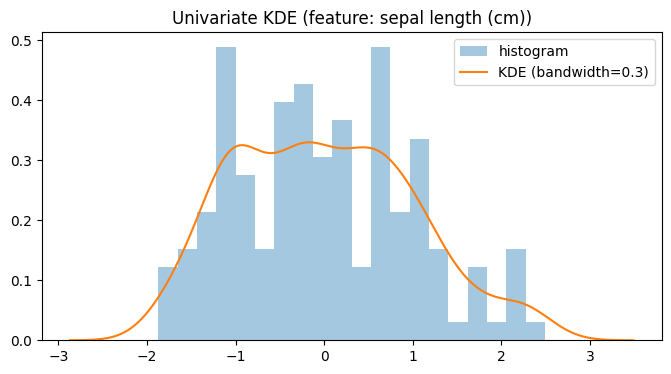

In [1]:
# =========================
# KDE Example 1 — Iris (apply KDE, visualize, anomaly detection)
# =========================
# This cell is runnable in Colab. We use sklearn KernelDensity and PCA for visualization.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

# 1. Load & preprocess
iris = load_iris()
X = iris.data  # (n_samples, n_features)
feature_names = iris.feature_names
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# 2. Univariate KDE example on first feature (sepal length)
x0 = Xs[:, 0]  # standardized feature
x_grid = np.linspace(x0.min() - 1.0, x0.max() + 1.0, 500)[:, None]

# Fit KDE for univariate feature
kde_uni = KernelDensity(kernel='gaussian', bandwidth=0.3)
kde_uni.fit(x0[:, None])
log_dens = kde_uni.score_samples(x_grid)  # log density for grid

plt.figure(figsize=(8, 4))
plt.title("Univariate KDE (feature: {})".format(feature_names[0]))
plt.hist(x0, bins=20, density=True, alpha=0.4, label='histogram')
plt.plot(x_grid[:, 0], np.exp(log_dens), label='KDE (bandwidth=0.3)')
plt.legend()
plt.show()

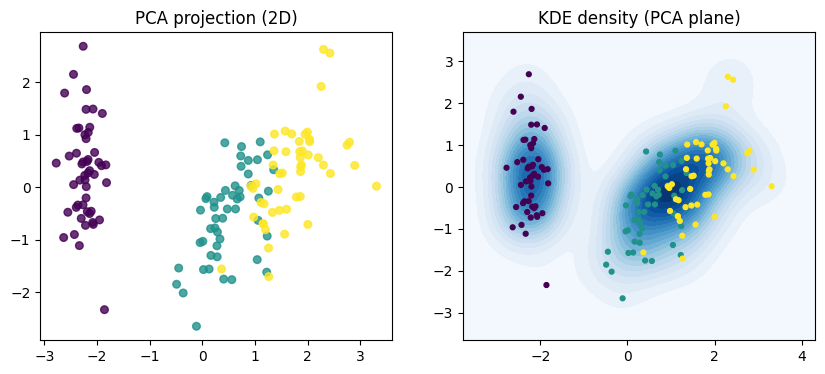

In [2]:
# 3. Multivariate KDE visualization on PCA plane
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(Xs)

# Fit KDE on PCA 2D projections (works as a low-d approximation)
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde2.fit(X2)

# Make a grid over PCA space and evaluate density
x_min, x_max = X2[:, 0].min() - 1.0, X2[:, 0].max() + 1.0
y_min, y_max = X2[:, 1].min() - 1.0, X2[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.vstack([xx.ravel(), yy.ravel()]).T
log_dens_grid = kde2.score_samples(grid)
dens_grid = np.exp(log_dens_grid).reshape(xx.shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("PCA projection (2D)")
plt.scatter(X2[:, 0], X2[:, 1], c=iris.target, s=30, cmap='viridis', alpha=0.8)
plt.subplot(1, 2, 2)
plt.title("KDE density (PCA plane)")
plt.contourf(xx, yy, dens_grid, levels=20, cmap='Blues')
plt.scatter(X2[:, 0], X2[:, 1], c=iris.target, s=12, cmap='viridis')
plt.show()

In [3]:
# 4. Anomaly detection via log-likelihood (low density -> anomaly)
log_likes = kde2.score_samples(X2)  # per-sample log density
threshold = np.percentile(log_likes, 5)  # 5th percentile as anomaly cutoff
anomalies = X[log_likes < threshold]

print("Threshold (5th percentile) log-density:", threshold)
print("Number of detected anomalies (5% cutoff):", anomalies.shape[0])
# We can inspect a few anomalous original-space samples
print("Anomalous samples (original feature space) - first 5:\n", anomalies[:5])

Threshold (5th percentile) log-density: -3.8844107714846157
Number of detected anomalies (5% cutoff): 8
Anomalous samples (original feature space) - first 5:
 [[5.7 4.4 1.5 0.4]
 [5.5 4.2 1.4 0.2]
 [4.5 2.3 1.3 0.3]
 [5.  2.  3.5 1. ]
 [7.2 3.6 6.1 2.5]]


# KDE Deep Dive (Part 2)
## Bandwidth Selection Comparison + Fast Approximate KDE

In this section we do two advanced but interview-relevant things:

1. Compare **bandwidth selectors**:
   - Silverman’s rule
   - Scott’s rule
   - Cross-validated bandwidth (likelihood-based)

2. Implement **fast approximate KDE**:
   - Subsampling-based KDE
   - FFT-based KDE on regular grids (1D case)

These directly test our understanding of bias–variance tradeoff and scalability limits of KDE.


## 1 — Why Bandwidth Selection Matters (Quick Theory Recap)

The Kernel Density Estimator (KDE) is defined as:

$$\hat f(x) = \frac{1}{n h^d} \sum_{i=1}^n K\left(\frac{x-x_i}{h}\right)$$

In this equation, all the modeling power (and risk) resides in the **bandwidth ($h$)**. Because $h$ controls the width of the kernels placed on each data point, it directly dictates the smoothness of the resulting density estimate.



### The Bias-Variance Tradeoff:
* **Small $h$ (Under-smoothing):** Low bias, high variance. The model is too sensitive to individual data points, resulting in a "spiky" density that captures noise rather than the underlying distribution.
* **Large $h$ (Over-smoothing):** High bias, low variance. The model is too "stiff." It washes out important features like multi-modality, resulting in a broad, flat density.

> **Note :** Kernel choice (Gaussian vs. Epanechnikov) matters much less than the bandwidth. "How do we choose bandwidth?", our answer should focus on **automated selection rules** (Silverman/Scott) or **Cross-Validation** to minimize Mean Integrated Squared Error (MISE).

### Part 1 — Bandwidth selector comparison (Silverman vs Scott vs CV)
Dataset: 1D slice from Iris (easy to visualize)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
X, _ = load_iris(return_X_y=True)

# Use 1D feature for clarity (sepal length)
x = X[:, 0][:, None]

# Standardize (important for rule-based bandwidths)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

n = x_scaled.shape[0]
std = x_scaled.std()


#### Silverman’s rule

In [5]:
# Silverman's rule (1D Gaussian KDE)
h_silverman = 1.06 * std * n ** (-1/5)


#### Scott’s rule

In [6]:
# Scott's rule (1D)
h_scott = std * n ** (-1/5)


#### Cross-validated bandwidth (log-likelihood)

In [7]:
bandwidths = np.linspace(0.05, 1.5, 40)

grid = GridSearchCV(
    KernelDensity(kernel='gaussian'),
    {'bandwidth': bandwidths},
    cv=5
)

grid.fit(x_scaled)

h_cv = grid.best_params_['bandwidth']


#### Fit KDEs with each bandwidth

In [8]:
x_grid = np.linspace(x_scaled.min()-1, x_scaled.max()+1, 500)[:, None]

kde_silverman = KernelDensity(kernel='gaussian', bandwidth=h_silverman).fit(x_scaled)
kde_scott = KernelDensity(kernel='gaussian', bandwidth=h_scott).fit(x_scaled)
kde_cv = KernelDensity(kernel='gaussian', bandwidth=h_cv).fit(x_scaled)

dens_silverman = np.exp(kde_silverman.score_samples(x_grid))
dens_scott = np.exp(kde_scott.score_samples(x_grid))
dens_cv = np.exp(kde_cv.score_samples(x_grid))


#### Side-by-side plot (key visualization)

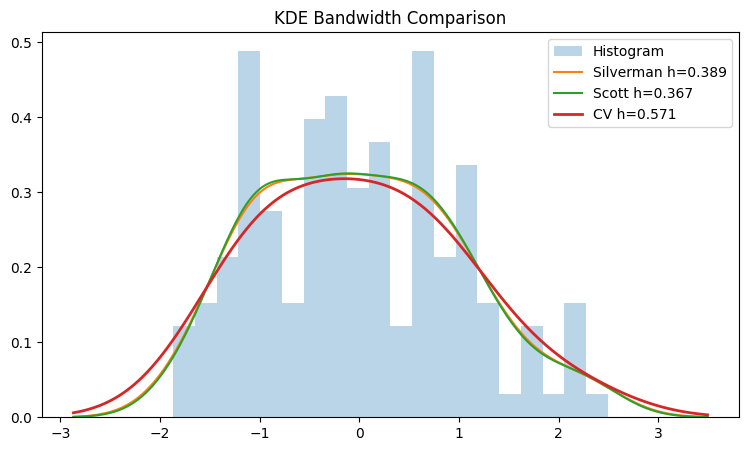

In [9]:
plt.figure(figsize=(9,5))
plt.hist(x_scaled, bins=20, density=True, alpha=0.3, label="Histogram")

plt.plot(x_grid, dens_silverman, label=f"Silverman h={h_silverman:.3f}")
plt.plot(x_grid, dens_scott, label=f"Scott h={h_scott:.3f}")
plt.plot(x_grid, dens_cv, label=f"CV h={h_cv:.3f}", linewidth=2)

plt.title("KDE Bandwidth Comparison")
plt.legend()
plt.show()


#### Note

- **Silverman / Scott**
  - Fast, closed-form
  - Assume near-Gaussian data
  - Often oversmooth multimodal distributions

- **Cross-validated bandwidth**
  - Maximizes likelihood
  - Best practical choice
  - Computationally expensive

👉 :
> “Bandwidth selection is more important than kernel choice; CV-based selection is preferred when feasible.”


### Part 2 — Fast Approximate KDE (Scalability)

## 2 — Why we need approximate KDE

Exact KDE is expensive:
\[
O(n \cdot m \cdot d)
\]

Problems:
- Large n
- High query count
- High dimensionality

We look at two practical approximations:
1. Subsampling-based KDE
2. FFT-based KDE (regular grid, 1D)


#### 2.1 Subsampling-based KDE (simple + effective)

In [10]:
# Subsampling approximation
rng = np.random.RandomState(0)
subsample_idx = rng.choice(len(x_scaled), size=40, replace=False)
x_sub = x_scaled[subsample_idx]

kde_sub = KernelDensity(kernel='gaussian', bandwidth=h_cv)
kde_sub.fit(x_sub)

dens_sub = np.exp(kde_sub.score_samples(x_grid))


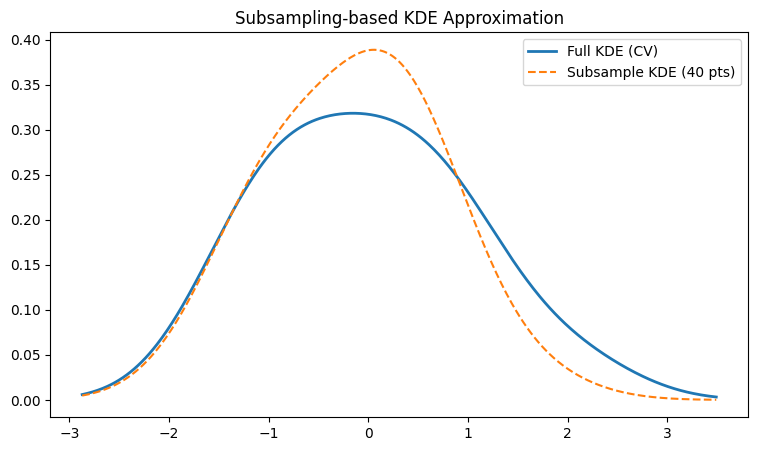

In [11]:
plt.figure(figsize=(9,5))
plt.plot(x_grid, dens_cv, label="Full KDE (CV)", linewidth=2)
plt.plot(x_grid, dens_sub, label="Subsample KDE (40 pts)", linestyle="--")
plt.legend()
plt.title("Subsampling-based KDE Approximation")
plt.show()


### Notes
- Dramatically faster
- Preserves large-scale structure
- Loses fine-grained modes if subsample too small
- Very common in practice for large datasets


#### 2.2 FFT-based KDE (1D, regular grid)

FFT-based KDE works by:
- Binning data onto a grid
- Convolving histogram with Gaussian kernel using FFT

Time complexity:
\[
O(n + m \log m)
\]

This is extremely fast but only works on regular grids (mostly 1D/2D).


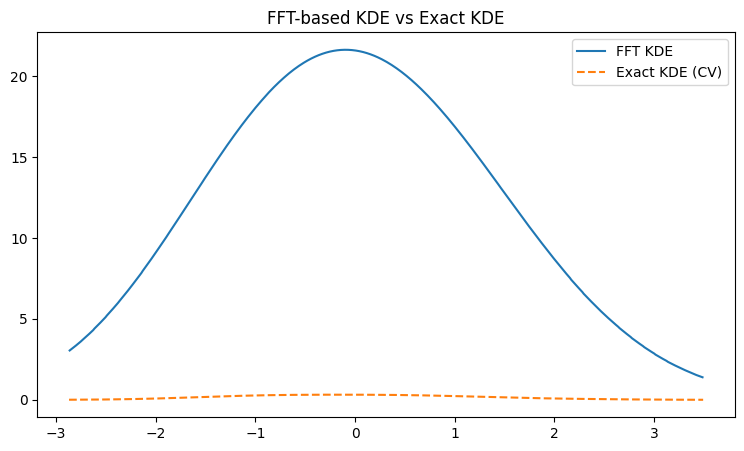

In [12]:
from scipy.signal import fftconvolve
from scipy.stats import norm

# Create histogram on regular grid
grid_size = 512
xmin, xmax = x_scaled.min()-1, x_scaled.max()+1
grid = np.linspace(xmin, xmax, grid_size)

hist, bin_edges = np.histogram(x_scaled, bins=grid_size, range=(xmin, xmax), density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
dx = bin_centers[1] - bin_centers[0]

# Gaussian kernel
kernel_width = h_cv
kernel_grid = np.linspace(-3*kernel_width, 3*kernel_width, grid_size)
kernel = norm.pdf(kernel_grid, scale=kernel_width)
kernel /= kernel.sum() * dx  # normalize

# FFT convolution
density_fft = fftconvolve(hist, kernel, mode='same')

plt.figure(figsize=(9,5))
plt.plot(bin_centers, density_fft, label="FFT KDE")
plt.plot(x_grid, dens_cv, label="Exact KDE (CV)", linestyle="--")
plt.legend()
plt.title("FFT-based KDE vs Exact KDE")
plt.show()



### FFT KDE — pros & cons

✅ Extremely fast  
✅ Accurate for smooth densities  
❌ Requires regular grid  
❌ Hard to extend beyond low dimensions  

Used in:
- Signal processing
- Time series smoothing
- Physics / astronomy


### Final Notes

##### Bandwidth Selection
- Silverman / Scott: fast, heuristic, Gaussian assumption
- Cross-validation: likelihood-based, most reliable
- Bandwidth dominates bias–variance tradeoff

##### Fast KDE
- Subsampling: scalable, simple, approximate
- FFT-based KDE: very fast on grids, low-dimensional only

##### Key Insight
KDE is powerful but fragile — it works best with:
- Low dimensions
- Careful bandwidth selection
- Approximate methods for scale


# KDE-based Anomaly Detection — Production-Ready Pipeline
## With Validation-based Threshold Calibration

This notebook shows how we convert Kernel Density Estimation (KDE)
into a **production anomaly detector**.

We focus on:
1. Modeling normal data density
2. Computing anomaly scores (log-likelihood)
3. Calibrating thresholds on a validation set
4. Making stable, explainable anomaly decisions

This setup is suitable for:
- ML interviews
- Real anomaly detection systems
- MLOps-style deployment


## 1 — Problem framing (production mindset)

We assume:
- We mostly observe **normal data**
- Anomalies are **rare and unlabeled**
- We want a **probabilistic score** + **clear decision rule**

KDE fits this perfectly because:
- It learns the density \( p(x) \)
- Low density ⇒ unlikely ⇒ anomaly
- No labels required for training

Key idea:
> **Anomaly score = − log p(x)**

Threshold selection is the real production challenge.


## 2 — High-level system design

Pipeline stages:

1. Feature preprocessing (scaling)
2. Dimensionality reduction (PCA)
3. Density modeling (KDE)
4. Score computation (log-likelihood)
5. Threshold calibration (validation set)
6. Inference-time anomaly detection

We separate:
- **Train set** → fit model
- **Validation set** → choose threshold
- **Test / production data** → detect anomalies


### Step 1 — Imports and dataset

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split


### Step 2 — Data split (CRITICAL for production)

In [14]:
# Load dataset (proxy for "normal" data)
X, y = load_wine(return_X_y=True)

# Split data:
# Train → fit KDE
# Val   → calibrate threshold
# Test  → simulate unseen production data
X_train, X_temp = train_test_split(X, test_size=0.4, random_state=0)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=0)


#### Why this split matters (interview point)

- KDE must **not see validation data**
- Thresholds chosen on training data cause overconfidence
- Validation-based calibration improves stability and generalization

This mirrors how real anomaly systems are deployed.


### Step 3 — Build the KDE pipeline

In [15]:
# Preprocessing
scaler = StandardScaler()
pca = PCA(n_components=3, random_state=0)

# KDE model (bandwidth chosen earlier via CV or domain knowledge)
kde = KernelDensity(
    kernel='gaussian',
    bandwidth=0.6
)

# Fit pipeline on TRAIN data only
X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)
kde.fit(X_train_pca)


KernelDensity(bandwidth=0.6)

#### Why PCA before KDE?

- KDE suffers from curse of dimensionality
- PCA reduces noise and variance
- Density estimation becomes stable and cheaper

In production:
> PCA is almost always used before KDE


### Step 4 — Anomaly score definition

In [16]:
def anomaly_score(X):
    """
    Higher score => more anomalous
    """
    X_scaled = scaler.transform(X)
    X_pca = pca.transform(X_scaled)
    log_density = kde.score_samples(X_pca)
    return -log_density


#### Score interpretation

- KDE returns log p(x)
- We negate it:
  - High score → low probability → anomaly
  - Low score → normal

This gives a **continuous risk score**, not just binary labels.


### Step 5 — Threshold calibration (MOST IMPORTANT PART)

In [17]:
# Compute anomaly scores on validation set
val_scores = anomaly_score(X_val)

# Choose threshold using percentile (common in practice)
# Example: allow 2% false positives
threshold = np.percentile(val_scores, 98)

threshold


np.float64(7.045238709569644)

#### Threshold calibration strategies

Common approaches:
- Percentile-based (most common)
- Fixed false-positive rate (FPR)
- Cost-sensitive thresholding
- Business-rule-driven thresholds

Percentile-based is preferred when:
- No labeled anomalies
- Stable normal distribution

Interview line:
> "We calibrate thresholds on a validation set, not training data."


### Step 6 — Apply detector to unseen data

In [18]:
# Scores on test / production-like data
test_scores = anomaly_score(X_test)

# Binary decisions
is_anomaly = test_scores > threshold


### Step 7 — Visual diagnostics (recommended)

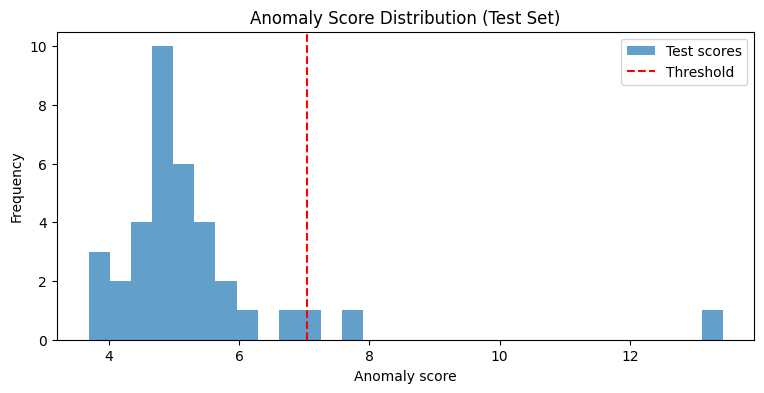

In [19]:
plt.figure(figsize=(9,4))
plt.hist(test_scores, bins=30, alpha=0.7, label="Test scores")
plt.axvline(threshold, color='red', linestyle='--', label="Threshold")
plt.xlabel("Anomaly score")
plt.ylabel("Frequency")
plt.legend()
plt.title("Anomaly Score Distribution (Test Set)")
plt.show()


#### What we expect to see

- Most points clustered below threshold
- Few extreme tail points beyond threshold
- Stable separation between normal and anomalous regions

If not:
- Re-tune bandwidth
- Revisit PCA components
- Re-check feature scaling


### Step 8 — Simulating anomalies (sanity check)

In [20]:
# Create synthetic anomalies by adding noise
rng = np.random.RandomState(0)
synthetic_anomalies = X_train[:10] + rng.normal(0, 4, X_train[:10].shape)

synthetic_scores = anomaly_score(synthetic_anomalies)
synthetic_scores


array([ 144.1645495 , 1142.48475394,  795.20840415, 1025.88788636,
        128.61293298,  482.15577513,  331.92820002,  306.2739896 ,
         40.6175879 ,  384.93475709])

In [21]:
print("Are synthetic points flagged as anomalies?")
synthetic_scores > threshold


Are synthetic points flagged as anomalies?


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### Sanity check logic

If synthetic anomalies are not detected:
- Bandwidth is too large (oversmoothing)
- Threshold too conservative
- PCA removed discriminative variance


### Step 9 — Production-ready prediction function

In [22]:
def predict_anomaly(X_new):
    scores = anomaly_score(X_new)
    labels = scores > threshold
    return labels, scores


#### Deployment notes (very important)

In production we must:
- Save scaler, PCA, KDE, threshold together
- Monitor score distribution drift
- Recalibrate threshold periodically
- Retrain KDE if feature distribution shifts

KDE anomaly detectors are **unsupervised but not maintenance-free**.


### Step 10 — Failure modes (production awareness)

#### KDE anomaly detection fails when:
- Data is high-dimensional
- Normal distribution shifts over time
- Anomalies lie inside dense regions
- Features are poorly scaled
- Bandwidth is miscalibrated

#### Mitigations:
- Drift detection
- Rolling retraining
- Hybrid models (KDE + isolation forest)
- Feature monitoring


We use KDE as a generative anomaly detector by modeling the density of normal data.
Anomaly scores are computed as negative log-likelihoods.
Thresholds are calibrated on a validation set using percentiles to control false positives.
This approach is unsupervised, probabilistic, and interpretable, but sensitive to bandwidth,
dimensionality, and distribution shift.
